In [27]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import LineString
from shapely.geometry import Point

In [2]:
def get_coordinates(country_name):
    geolocator = Nominatim(user_agent="migration_map")
    
    try:
        location = geolocator.geocode(country_name)
        if location:
            return location.latitude, location.longitude
        else:
            # If the country is not found, return None (or handle it differently)
            return None
    except Exception as e:
        print(f"Error retrieving coordinates for {country_name}: {e}")
        return None


In [3]:
both_gender_1960 = pd.read_csv('data/both_gender/1960.csv')[["Origin_name",	"Origin_code","Destination_name","Destination_code","1960"]]
both_gender_1960['1960'] = pd.to_numeric(both_gender_1960['1960'], errors='coerce').fillna(0).astype(int)
both_gender_1960 = both_gender_1960[both_gender_1960['1960'] != 0]
both_gender_1960

,Origin_name,Origin_code,Destination_name,Destination_code,1960
2,Afghanistan,AFG,Algeria,DZA,41
8,Afghanistan,AFG,Argentina,ARG,6
11,Afghanistan,AFG,Australia,AUS,42
12,Afghanistan,AFG,Austria,AUT,47
15,Afghanistan,AFG,Bahrain,BHR,62
...,...,...,...,...,...
53563,Zimbabwe,ZWE,Tanzania,TZA,1415
53575,Zimbabwe,ZWE,Uganda,UGA,5
53578,Zimbabwe,ZWE,United Kingdom,GBR,176
53579,Zimbabwe,ZWE,United States,USA,331


## Looking just at UNITED STATES

In [4]:
US_df = both_gender_1960[(both_gender_1960['Origin_name'] == "United States") |(both_gender_1960['Destination_name'] == "United States")]
US_df

,Origin_name,Origin_code,Destination_name,Destination_code,1960
218,Afghanistan,AFG,United States,USA,293
449,Albania,ALB,United States,USA,10047
680,Algeria,DZA,United States,USA,322
911,American Samoa,ASM,United States,USA,2519
1142,Andorra,AND,United States,USA,440
...,...,...,...,...,...
52424,"Virgin Islands, British",VGB,United States,USA,356
52886,West Bank and Gaza,PSE,United States,USA,31
53117,"Yemen, Rep.",YEM,United States,USA,184
53348,Zambia,ZMB,United States,USA,181


In [5]:
US_leave = US_df[US_df['Origin_name'] == "United States"]
US_to =  US_df[US_df['Destination_name'] == "United States"]
US_to

,Origin_name,Origin_code,Destination_name,Destination_code,1960
218,Afghanistan,AFG,United States,USA,293
449,Albania,ALB,United States,USA,10047
680,Algeria,DZA,United States,USA,322
911,American Samoa,ASM,United States,USA,2519
1142,Andorra,AND,United States,USA,440
...,...,...,...,...,...
52424,"Virgin Islands, British",VGB,United States,USA,356
52886,West Bank and Gaza,PSE,United States,USA,31
53117,"Yemen, Rep.",YEM,United States,USA,184
53348,Zambia,ZMB,United States,USA,181


In [6]:
# Create a directed graph
G_leave = nx.DiGraph()

# Add edges to the graph, with origin and destination as nodes
for _, row in US_leave.iterrows():
    G_leave.add_edge(row['Origin_name'], row['Destination_name'], weight=row['1960'])

KeyboardInterrupt: 

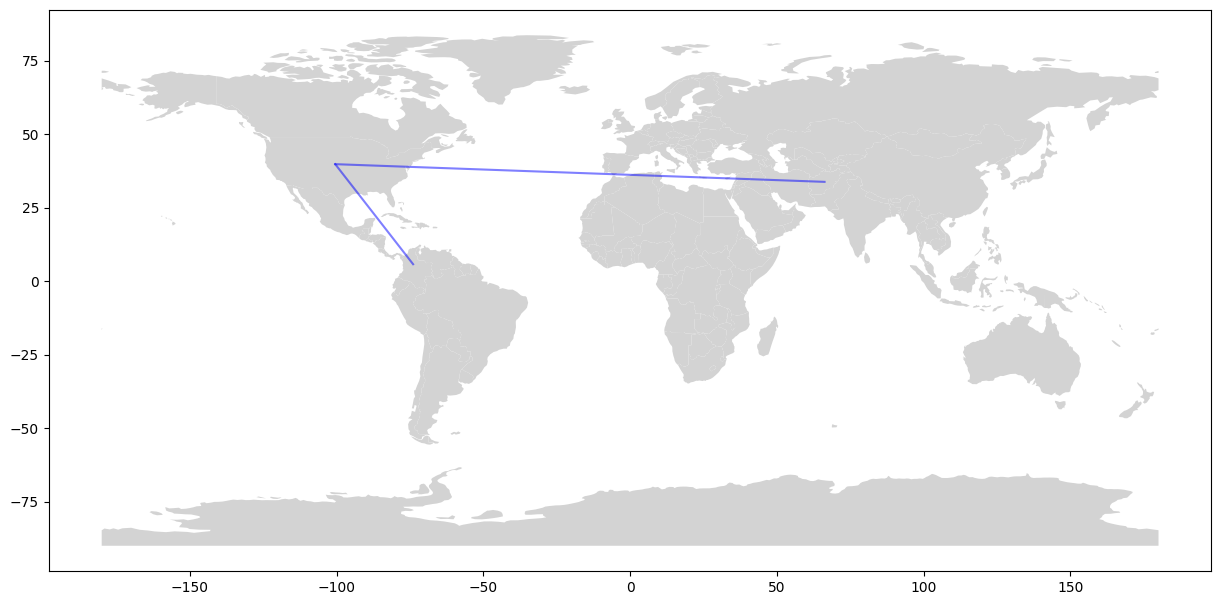

In [7]:
# Assuming you have your migration graph already created (G is your directed graph)

# Load the world map from a custom shapefile
shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Plot the world map
ax = world.plot(figsize=(15, 10), color='lightgrey')

# Add edges from the migration graph to the plot
for edge in G_leave.edges():
    origin, destination = edge
    origin_coords = get_coordinates(origin)
    destination_coords = get_coordinates(destination)
    
    if origin_coords and destination_coords:
        # Plot the line between the origin and destination on the map
        plt.plot([origin_coords[1], destination_coords[1]], 
                 [origin_coords[0], destination_coords[0]], color='blue', alpha=0.5)

# Show the plot
plt.title('Countries Leaving United States')
plt.show()


In [8]:
G_to = nx.from_pandas_edgelist(
    US_to,
    source='Origin_code',
    target='Destination_code',
    edge_attr='1960',
    create_using=nx.DiGraph()
)


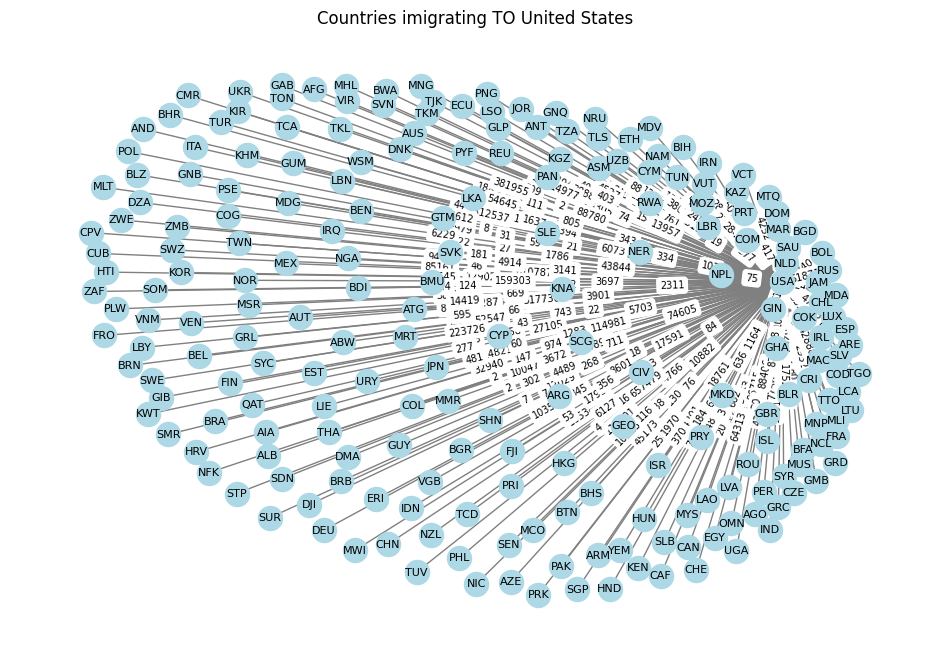

In [9]:
# Choose a layout
pos = nx.spring_layout(G_to, k=0.5, seed=42)

# Draw nodes and edges
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_to, pos, node_size=300, node_color='lightblue')
nx.draw_networkx_edges(G_to, pos, arrowstyle='->', arrowsize=10, edge_color='gray')

# Draw labels for nodes
nx.draw_networkx_labels(G_to, pos, font_size=8)

# (Optional) Draw edge labels (the migration counts)
edge_labels = nx.get_edge_attributes(G_to, '1960')
nx.draw_networkx_edge_labels(G_to, pos, edge_labels=edge_labels, font_size=7)

plt.axis('off')
plt.title('Countries imigrating TO United States')
plt.show()


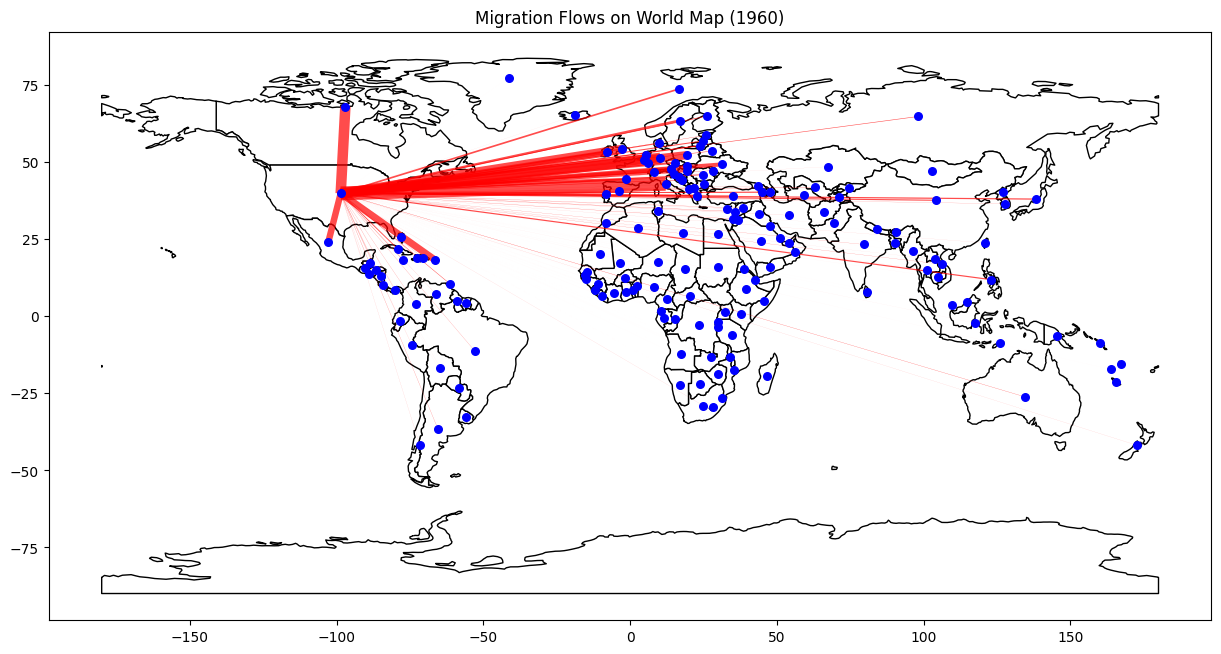

In [28]:
# Load world map from GeoPandas
# Assuming you have your migration graph already created (G is your directed graph)

# Load the world map from a custom shapefile
shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Make sure ISO codes match your dataset’s format
# For example, if your codes are uppercase like "AFG", ensure the shapefile codes are too
world['ADM0_A3'] = world['ADM0_A3'].str.upper()

# Create a column with centroid geometry for each country polygon
# This yields a Point geometry representing the centroid of the country
world_proj = world.to_crs(epsg=3857)

# 3. Calculate centroids in the projected CRS
world_proj['centroid'] = world_proj.geometry.centroid

# 4. Convert the centroids back to lat-lon
#    We switch the GeoDataFrame to use the 'centroid' column as its geometry
world_proj = world_proj.set_geometry('centroid')
world_proj = world_proj.to_crs(epsg=4326)

# 5. Now 'world_proj.geometry' holds centroid points in lat-lon. 
#    You can store them back in the original 'world' GeoDataFrame if you like:
world['centroid'] = world_proj.geometry
# Approximate center of the contiguous US
contig_us_center = Point(-98.58, 39.83)  # (lon, lat)

# Override the centroid for the USA row
world.loc[world['ADM0_A3'] == 'USA', 'centroid'] = contig_us_center

# 4.1: Merge df with world to get origin geometry
df_merged = US_to.merge(
    world[['ADM0_A3', 'centroid']], 
    left_on='Origin_code', 
    right_on='ADM0_A3', 
    how='left'
)

# Rename the centroid column to something like origin_centroid
df_merged = df_merged.rename(columns={'centroid': 'origin_centroid'})
df_merged.drop(columns='ADM0_A3', inplace=True)

# 4.2: Merge again to get destination geometry
df_merged = df_merged.merge(
    world[['ADM0_A3', 'centroid']], 
    left_on='Destination_code', 
    right_on='ADM0_A3', 
    how='left'
)
df_merged = df_merged.rename(columns={'centroid': 'destination_centroid'})
df_merged.drop(columns='ADM0_A3', inplace=True)

df_merged = df_merged[df_merged['origin_centroid'] != None]


def create_linestring(row):
    # row['origin_centroid'] and row['destination_centroid'] are Shapely Points
    orig_point = row['origin_centroid']
    dest_point = row['destination_centroid']
    
    # If either is NaN or missing, return None
    if pd.isnull(orig_point) or pd.isnull(dest_point):
        return None
    
    return LineString([orig_point, dest_point])

df_merged['geometry'] = df_merged.apply(create_linestring, axis=1)

# Drop rows where geometry is None
df_merged = df_merged.dropna(subset=['geometry'])

# Convert this DataFrame to a GeoDataFrame
gdf_edges = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")


# Plot setup
fig, ax = plt.subplots(figsize=(15,10))

# 6.1 Plot the world map
world.plot(ax=ax, color='white', edgecolor='black')

# For example, define a scale factor
max_migration = gdf_edges['1960'].max()
scale_factor = 10.0 / max_migration  # tweak to taste

gdf_edges.plot(
    ax=ax,
    color='red',
    linewidth=gdf_edges['1960'] * scale_factor,
    alpha=0.7
)

# -- (Optional) ADD NODE MARKERS BELOW -- #
# We gather all unique origin and destination points in a separate GeoDataFrame
all_points = []

# Extract origin points
tmp_orig = df_merged[['Origin_code', 'origin_centroid']].drop_duplicates()
tmp_orig = tmp_orig.rename(columns={
    'Origin_code': 'country_code',
    'origin_centroid': 'geometry'
})
all_points.append(tmp_orig)

# Extract destination points
tmp_dest = df_merged[['Destination_code', 'destination_centroid']].drop_duplicates()
tmp_dest = tmp_dest.rename(columns={
    'Destination_code': 'country_code',
    'destination_centroid': 'geometry'
})
all_points.append(tmp_dest)

# Concatenate origin & destination points, drop duplicates
df_points = pd.concat(all_points).drop_duplicates('country_code')
# print(df_points)

# Make a GeoDataFrame
gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry', crs="EPSG:4326")

# Finally, plot the points on top of the map and lines
gdf_points.plot(
    ax=ax,
    color='blue',
    markersize=30,  # Adjust as desired
    zorder=4        # Ensures markers appear above the lines
)

plt.title("Migration Flows on World Map (1960)")
plt.show()


In [10]:
# Load world map from GeoPandas
# Assuming you have your migration graph already created (G is your directed graph)

# Load the world map from a custom shapefile
shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Make sure ISO codes match your dataset’s format
# For example, if your codes are uppercase like "AFG", ensure the shapefile codes are too
world['ADM0_A3'] = world['ADM0_A3'].str.upper()

# Create a column with centroid geometry for each country polygon
# This yields a Point geometry representing the centroid of the country
world_proj = world.to_crs(epsg=3857)

# 3. Calculate centroids in the projected CRS
world_proj['centroid'] = world_proj.geometry.centroid

# 4. Convert the centroids back to lat-lon
#    We switch the GeoDataFrame to use the 'centroid' column as its geometry
world_proj = world_proj.set_geometry('centroid')
world_proj = world_proj.to_crs(epsg=4326)

# 5. Now 'world_proj.geometry' holds centroid points in lat-lon. 
#    You can store them back in the original 'world' GeoDataFrame if you like:
world['centroid'] = world_proj.geometry

# world.to_csv("world_data.csv")
# world

In [11]:
# 4.1: Merge df with world to get origin geometry
df_merged = US_to.merge(
    world[['ADM0_A3', 'centroid']], 
    left_on='Origin_code', 
    right_on='ADM0_A3', 
    how='left'
)

# Rename the centroid column to something like origin_centroid
df_merged = df_merged.rename(columns={'centroid': 'origin_centroid'})
df_merged.drop(columns='ADM0_A3', inplace=True)

# 4.2: Merge again to get destination geometry
df_merged = df_merged.merge(
    world[['ADM0_A3', 'centroid']], 
    left_on='Destination_code', 
    right_on='ADM0_A3', 
    how='left'
)
df_merged = df_merged.rename(columns={'centroid': 'destination_centroid'})
df_merged.drop(columns='ADM0_A3', inplace=True)

df_merged = df_merged[df_merged['origin_centroid'] != None]
df_merged

,Origin_name,Origin_code,Destination_name,Destination_code,1960,origin_centroid,destination_centroid
0,Afghanistan,AFG,United States,USA,293,POINT (66.12826 33.93667),POINT (-119.45018 51.26001)
1,Albania,ALB,United States,USA,10047,POINT (20.03154 41.1538),POINT (-119.45018 51.26001)
2,Algeria,DZA,United States,USA,322,POINT (2.59661 28.44987),POINT (-119.45018 51.26001)
5,Angola,AGO,United States,USA,141,POINT (17.4732 -12.30289),POINT (-119.45018 51.26001)
8,Argentina,ARG,United States,USA,17591,POINT (-65.4182 -36.7045),POINT (-119.45018 51.26001)
...,...,...,...,...,...,...,...
210,"Venezuela, RB",VEN,United States,USA,7287,POINT (-66.1692 7.18082),POINT (-119.45018 51.26001)
211,Vietnam,VNM,United States,USA,14419,POINT (106.26223 16.82176),POINT (-119.45018 51.26001)
215,"Yemen, Rep.",YEM,United States,USA,184,POINT (47.54565 15.92826),POINT (-119.45018 51.26001)
216,Zambia,ZMB,United States,USA,181,POINT (27.71108 -13.42741),POINT (-119.45018 51.26001)


In [12]:
def create_linestring(row):
    # row['origin_centroid'] and row['destination_centroid'] are Shapely Points
    orig_point = row['origin_centroid']
    dest_point = row['destination_centroid']
    
    # If either is NaN or missing, return None
    if pd.isnull(orig_point) or pd.isnull(dest_point):
        return None
    
    return LineString([orig_point, dest_point])

df_merged['geometry'] = df_merged.apply(create_linestring, axis=1)

# Drop rows where geometry is None
df_merged = df_merged.dropna(subset=['geometry'])

# Convert this DataFrame to a GeoDataFrame
gdf_edges = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")


In [13]:
# For example, define a scale factor
max_migration = gdf_edges['1960'].max()
scale_factor = 5.0 / max_migration  # tweak to taste

gdf_edges.plot(
    ax=ax,
    color='red',
    linewidth=gdf_edges['1960'] * scale_factor,
    alpha=0.7
)


<Axes: >

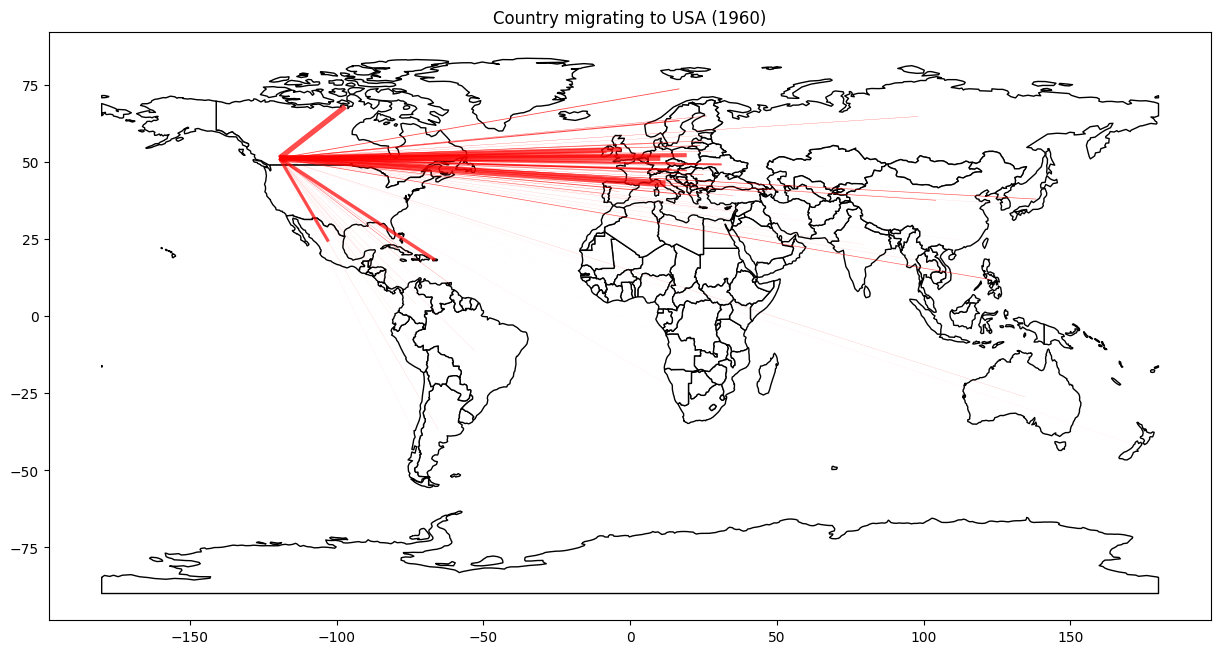

In [22]:
# Plot setup
fig, ax = plt.subplots(figsize=(15,10))

# 6.1 Plot the world map
world.plot(ax=ax, color='white', edgecolor='black')

# For example, define a scale factor
max_migration = gdf_edges['1960'].max()
scale_factor = 5.0 / max_migration  # tweak to taste

gdf_edges.plot(
    ax=ax,
    color='red',
    linewidth=gdf_edges['1960'] * scale_factor,
    alpha=0.7
)

plt.title("Country migrating to USA (1960)")
plt.show()


    country_code                     geometry
0            AFG    POINT (66.12826 33.93667)
1            ALB     POINT (20.03154 41.1538)
2            DZA     POINT (2.59661 28.44987)
5            AGO    POINT (17.4732 -12.30289)
8            ARG    POINT (-65.4182 -36.7045)
..           ...                          ...
211          VNM   POINT (106.26223 16.82176)
215          YEM    POINT (47.54565 15.92826)
216          ZMB   POINT (27.71108 -13.42741)
217          ZWE    POINT (29.78843 -18.9298)
0            USA  POINT (-119.45018 51.26001)

[166 rows x 2 columns]


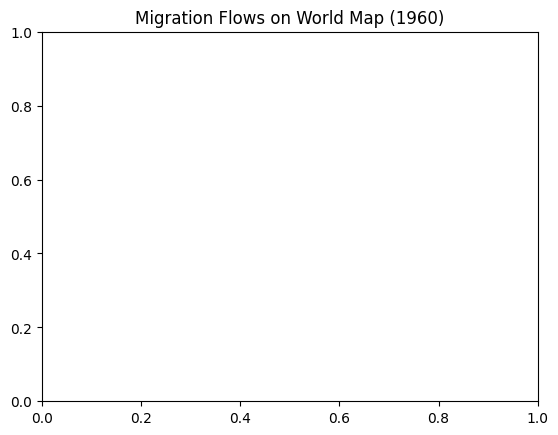

In [23]:
# -- (Optional) ADD NODE MARKERS BELOW -- #
# We gather all unique origin and destination points in a separate GeoDataFrame
all_points = []

# Extract origin points
tmp_orig = df_merged[['Origin_code', 'origin_centroid']].drop_duplicates()
tmp_orig = tmp_orig.rename(columns={
    'Origin_code': 'country_code',
    'origin_centroid': 'geometry'
})
all_points.append(tmp_orig)

# Extract destination points
tmp_dest = df_merged[['Destination_code', 'destination_centroid']].drop_duplicates()
tmp_dest = tmp_dest.rename(columns={
    'Destination_code': 'country_code',
    'destination_centroid': 'geometry'
})
all_points.append(tmp_dest)

# Concatenate origin & destination points, drop duplicates
df_points = pd.concat(all_points).drop_duplicates('country_code')
print(df_points)

# Make a GeoDataFrame
gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry', crs="EPSG:4326")

# Finally, plot the points on top of the map and lines
gdf_points.plot(
    ax=ax,
    color='blue',
    markersize=30,  # Adjust as desired
    zorder=4        # Ensures markers appear above the lines
)

plt.title("Migration Flows on World Map (1960)")
plt.show()

In [55]:
# Extract all unique centroids
all_points = []

for c in ['Origin_code', 'Destination_code']:
    tmp = df_merged[[c, f'{c.lower()}_centroid']].drop_duplicates()
    tmp = tmp.rename(columns={
        c: 'country_code',
        f'{c.lower()}_centroid': 'geometry'
    })
    all_points.append(tmp)

# Combine them
df_points = pd.concat(all_points).drop_duplicates('country_code')

gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry', crs="EPSG:4326")

# Plot points on the same map
gdf_points.plot(ax=ax, color='blue', markersize=10)


KeyError: "['origin_code_centroid'] not in index"

In [28]:
# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph, with origin and destination as nodes
for _, row in both_gender_1960.iterrows():
    G.add_edge(row['Origin_name'], row['Destination_name'], weight=row['1960'])

Error retrieving coordinates for Venezuela, RB: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Venezuela%2C+RB&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error retrieving coordinates for Virgin Islands (U.S.): HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Virgin+Islands+%28U.S.%29&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error retrieving coordinates for Venezuela, RB: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Venezuela%2C+RB&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error retr

KeyboardInterrupt: 

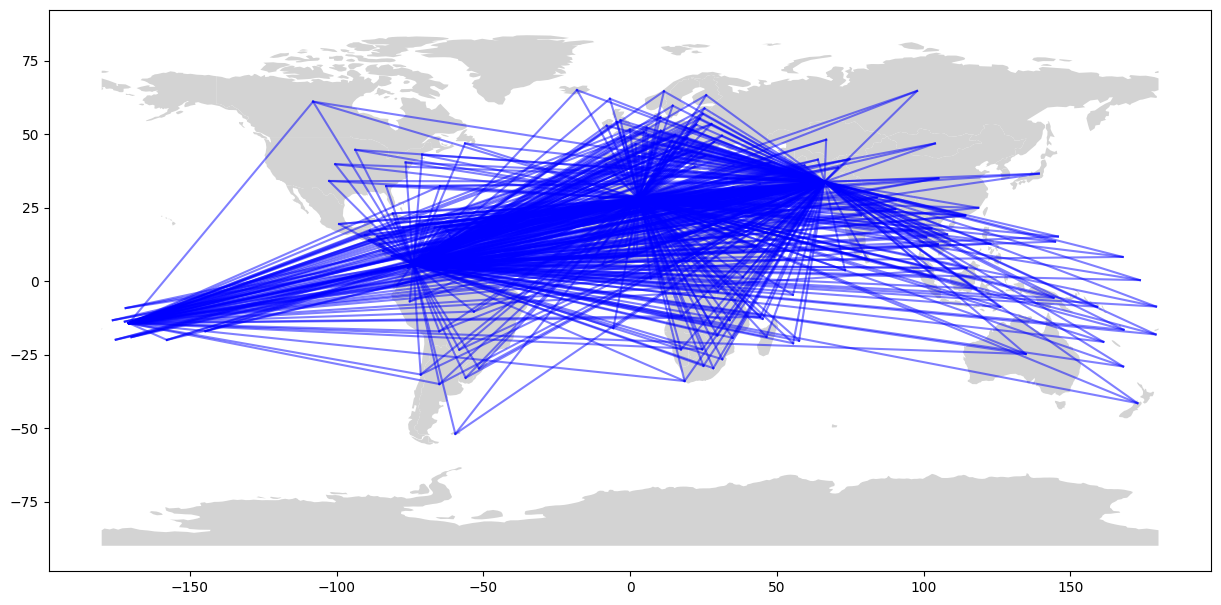

In [30]:
# Assuming you have your migration graph already created (G is your directed graph)

# Load the world map from a custom shapefile
shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Plot the world map
ax = world.plot(figsize=(15, 10), color='lightgrey')

# Add edges from the migration graph to the plot
for edge in G.edges():
    origin, destination = edge
    origin_coords = get_coordinates(origin)
    destination_coords = get_coordinates(destination)
    
    if origin_coords and destination_coords:
        # Plot the line between the origin and destination on the map
        plt.plot([origin_coords[1], destination_coords[1]], 
                 [origin_coords[0], destination_coords[0]], color='blue', alpha=0.5)

# Show the plot
plt.show()
